In [2]:
%load_ext lab_black

In [4]:
from time import sleep

import requests as r
import numpy as np
import pandas as pd

from utils import transform_data, get_data_from_api

In [5]:
df_beer = get_data_from_api()

# EDA

#### Objetivo do modelo -> treine um modelo de machine learning que classifique as cervejas em seus respectivos ibus.

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df_beer = df_beer.drop(columns=["id"])

## Nulos

In [5]:
# null values
(df_beer.isnull().sum() / df_beer.shape[0]) * 100

name         0.000000
abv          0.000000
ibu          1.538462
target_fg    0.307692
target_og    0.307692
ebc          1.846154
srm          1.846154
ph           0.615385
dtype: float64

Somente 1.53% das cervejas estão sem os valores de ibu. Vamos ver quais são.

#### ibu

In [6]:
df_beer[df_beer.ibu.isnull()]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
23,The End Of History,55.0,NaN,1000.0,1112.0,NaN,NaN,4.4
168,AB:19,13.1,NaN,NaN,NaN,NaN,NaN,NaN
234,Mango And Chili Barley Wine,12.0,NaN,1015.0,1110.0,20.0,40.0,4.4
235,Science IPA,5.0,NaN,1011.0,1050.0,24.0,47.0,4.4
236,Honey And Lemon Blitz,3.2,NaN,1008.0,1039.0,8.0,4.0,3.2


A primeira, end of history, tem um valor bem alto para abv, que já seria um outlier e que
provavelmemt tirariamos do dataset, a segunda está com quase todos os valores nulos, então sobram 3, que é uma quantidade muito baixa perto do tamanho do dataset.
Então, vamos tirar todas elas do dataset.

In [7]:
df_beer = df_beer[~df_beer.ibu.isnull()].reset_index(drop=True)

In [8]:
(df_beer.isnull().sum() / df_beer.shape[0]) * 100

name         0.0000
abv          0.0000
ibu          0.0000
target_fg    0.0000
target_og    0.0000
ebc          1.2500
srm          1.2500
ph           0.3125
dtype: float64

#### ebc

In [9]:
df_beer[df_beer.ebc.isnull()]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
18,Hello My Name Is Mette-Marit,8.2,70.0,1013.0,1076.0,NaN,NaN,4.4
33,Berliner Weisse With Raspberries And Rhubarb -...,3.6,8.0,1007.0,1040.0,NaN,NaN,3.2
128,Spiced Cherry Sour - B-Sides,6.5,20.0,1010.0,1060.0,NaN,NaN,3.2
147,AB:03,10.5,14.0,1013.0,1093.0,NaN,NaN,4.4


In [10]:
# Olhando no site da brewdog essas cervejas , quase todas as cervejas que tem o ebc nulo são experimentais
# por tanto, vamos tirar tbm.
df_beer = df_beer[~df_beer.ebc.isnull()].reset_index(drop=True)

In [11]:
(df_beer.isnull().sum() / df_beer.shape[0]) * 100

name         0.000000
abv          0.000000
ibu          0.000000
target_fg    0.000000
target_og    0.000000
ebc          0.000000
srm          0.000000
ph           0.316456
dtype: float64

#### ph

In [12]:
df_beer[df_beer.ph.isnull()]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
16,AB:06,11.2,150.0,1013.0,1098.0,70.0,35.0,NaN


Também é uma cerveja experimental, vamos tirar.

In [13]:
df_beer = df_beer[~df_beer.ph.isnull()].reset_index(drop=True)

In [14]:
(df_beer.isnull().sum() / df_beer.shape[0]) * 100

name         0.0
abv          0.0
ibu          0.0
target_fg    0.0
target_og    0.0
ebc          0.0
srm          0.0
ph           0.0
dtype: float64

In [15]:
df_beer_without_null = df_beer.copy(deep=True)

## Distribuição dos dados

<AxesSubplot:>

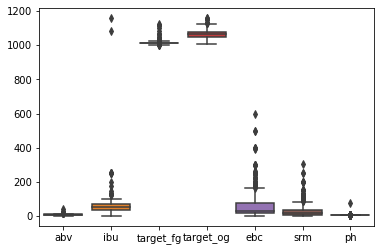

In [16]:
sns.boxplot(data=df_beer_without_null.drop(columns=["name"]))

Temos valores bem anomalos em ibu, vamos checar.

### ibu

<AxesSubplot:>

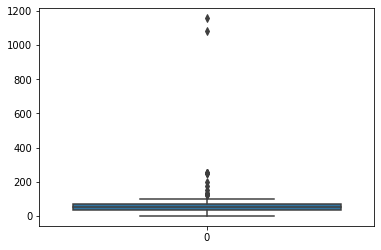

In [17]:
sns.boxplot(data=df_beer_without_null.ibu)

In [18]:
df_beer_without_null.iloc[df_beer_without_null.ibu.idxmax(), :]

name         Tactical Nuclear Penguin
abv                                32
ibu                              1157
target_fg                        1028
target_og                        1157
ebc                               250
srm                               127
ph                                4.4
Name: 177, dtype: object

In [19]:
df_beer_without_null[df_beer_without_null.ibu > 400]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
131,Sink The Bismarck!,41.0,1085.0,1016.0,1085.0,40.0,20.0,4.4
177,Tactical Nuclear Penguin,32.0,1157.0,1028.0,1157.0,250.0,127.0,4.4


Pesquisando na internet, vi que essas não são cervejas comuns e que talvez possuam essa quantidade de IBU, mesmo sendo outliers elas são ocorrencias reais, e não erros, então vamos deixar.

### ph

<AxesSubplot:>

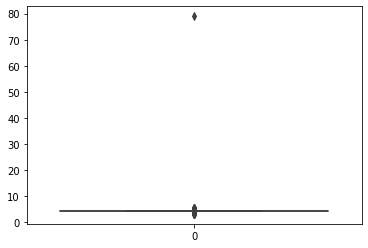

In [20]:
sns.boxplot(data=df_beer_without_null.ph)

In [21]:
df_beer_without_null[df_beer_without_null.ph > 14]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
306,Al Adjore!,9.0,65.0,1018.0,1085.0,35.0,18.0,79.0


pH é uma medida que varia de 0 a 14, sendo 79 um valor impossível. Como é somente um registro, vamos tirar.

In [22]:
df_beer_without_null = df_beer_without_null.query("ph < 15").reset_index(drop=True)

### ebc

<AxesSubplot:>

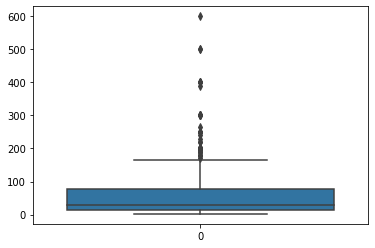

In [23]:
sns.boxplot(data=df_beer_without_null.ebc)

In [24]:
df_beer_without_null.query("ebc > 300")

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
75,AB:04,15.0,80.0,1018.0,1113.0,400.0,200.0,4.0
124,Hinterland,9.0,85.0,1025.0,1094.0,400.0,200.0,4.3
169,Dog D,16.1,85.0,1015.0,1125.0,400.0,200.0,4.3
208,Barrel Aged Hinterland,9.0,85.0,1025.0,1094.0,400.0,200.0,4.3
214,Dog E,16.1,100.0,1125.0,1015.0,500.0,254.0,4.4
282,I Wanna Be Your Dog,12.0,55.0,1035.0,1125.0,600.0,305.0,4.1
301,Dog G,17.0,100.0,1015.0,1125.0,500.0,254.0,4.4
302,Mallow Mafia,12.0,75.0,1025.0,1116.0,390.0,198.0,4.4


Novamente, os valores de EBC mesmo sendo altos, são verdadeiros, vamos deixar. [Receitas](https://brewdogrecipes.com/recipes/barrel-aged-hinterland)

## Correlação

Text(0.5, 1.0, 'Correlation Heatmap')

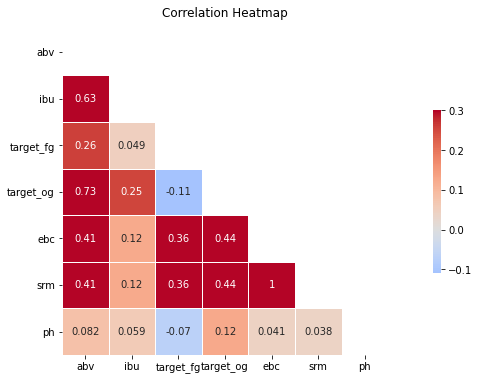

In [25]:
plt.figure(figsize=(16, 6))

corr = df_beer_without_null.drop(columns=["name"]).corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    mask=mask,
    vmax=0.3,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 12}, pad=12)

<AxesSubplot:xlabel='ebc', ylabel='srm'>

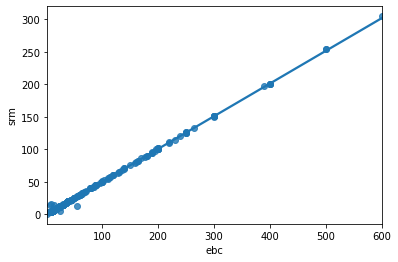

In [26]:
sns.regplot(x="ebc", y="srm", data=df_beer_without_null)

SRM e EBC são variaveis altamente correlacionas, se formos fazer um modelo de regressao precisamos tomar cuidado com elas.

In [27]:
df_beer_without_null[df_beer_without_null.ibu == 1085.0]

,name,abv,ibu,target_fg,target_og,ebc,srm,ph
131,Sink The Bismarck!,41.0,1085.0,1016.0,1085.0,40.0,20.0,4.4


# Feature Engineering

## Tipo

As cervejas são divididas em dois grupos principais, Ales e Largers. Vamos tentar inferir os tipos pelos nomes das cervejas.

In [28]:
def ale_or_pilsen(text):
    if "ale" in text.lower():
        return "ale"
    elif "lager" in text.lower():
        return "lager"
    else:
        return "who_knows"

In [29]:
df_beer_without_null.name.apply(ale_or_pilsen).value_counts(normalize=True)

who_knows    0.910828
ale          0.060510
lager        0.028662
Name: name, dtype: float64

In [30]:
df_beer_without_null["type"] = df_beer_without_null.name.apply(ale_or_pilsen)

## Cor

Para modelos de arvore é sempre bom agruparmos nossos dados continuos, 
fazendo um tipo de feature engineering conhecido como bucket ou binagem. 
Faremos isso com as escalas de coloração SRM e EBC, como elas são correlacionadas,
podemos usar qualquer uma para esse agrupamento.

Iremos usar como base a seguinte imagem
![lovibond](imagens/chart_beer_hues.jpg)

Porém, esse diagrama usa uma terceira escala de color conhecida como lovibond, então precisamos converter a SRM ou a EBC para adequarmos ao diagrama.

Procurando na internet, vi que a conversão segue a seguinte fórmula:  
˚L = EBC/1.97

In [31]:
def ebc_to_group(ebc_color: float) -> str:
    lovibond = ebc_color / 1.97
    if lovibond <= 7.5:
        return "yellow"
    elif lovibond > 7.5 and lovibond <= 14:
        return "amber"
    elif lovibond > 14 and lovibond <= 25:
        return "brown"
    elif lovibond > 25:
        return "black"

In [32]:
df_beer_without_null.ebc.apply(ebc_to_group).value_counts(normalize=True)

black     0.321656
amber     0.315287
yellow    0.181529
brown     0.181529
Name: ebc, dtype: float64

In [33]:
df_beer_without_null["color_group"] = df_beer_without_null.ebc.apply(ebc_to_group)

In [34]:
df_beer_without_null.head()

,name,abv,ibu,target_fg,target_og,ebc,srm,ph,type,color_group
0,Buzz,4.5,60.0,1010.0,1044.0,20.0,10.0,4.4,who_knows,amber
1,Trashy Blonde,4.1,41.5,1010.0,1041.7,15.0,15.0,4.4,who_knows,amber
2,Berliner Weisse With Yuzu - B-Sides,4.2,8.0,1007.0,1040.0,8.0,4.0,3.2,who_knows,yellow
3,Pilsen Lager,6.3,55.0,1012.0,1060.0,30.0,15.0,4.4,lager,brown
4,Avery Brown Dredge,7.2,59.0,1027.0,1069.0,10.0,5.0,4.4,who_knows,yellow


## Acidez

Acidez da cerveja é um fator que influencia diretamente no amargor da cerveja, vamos fazer um agrupamento entre elas

In [35]:
df_beer_without_null.ph.value_counts()

4.4    189
4.2     38
5.2     28
4.3     11
4.1     11
4.6      8
3.2      6
4.0      5
5.1      4
5.3      4
4.5      4
3.8      2
3.5      2
5.6      1
3.6      1
Name: ph, dtype: int64

In [36]:
pd.cut(df_beer_without_null.ph, bins=4).value_counts()

(3.8, 4.4]      254
(5.0, 5.6]       37
(4.4, 5.0]       12
(3.198, 3.8]     11
Name: ph, dtype: int64

In [37]:
df_beer_without_null["ph_group"] = pd.cut(df_beer_without_null.ph, bins=4).apply(str)

# Model

In [38]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [39]:
objects_columns = df_beer_without_null.select_dtypes("object").columns

In [40]:
df_beer_without_null[objects_columns] = df_beer_without_null[objects_columns].astype(
    "category"
)

In [41]:
df_beer_without_null = df_beer_without_null.drop(columns=["name"])

In [42]:
df_beer_dummies = pd.get_dummies(
    df_beer_without_null, columns=["type", "color_group", "ph_group"]
)

In [43]:
X_dummies = df_beer_dummies.drop(columns=["ibu"])
y_dummies = df_beer_dummies.ibu

X = df_beer_without_null.drop(columns=["ibu"])
y = df_beer_without_null.ibu

In [44]:
X_train_dummies, X_test_dummies, y_train_dummies, y_test_dummies = train_test_split(
    X_dummies,
    y_dummies,
    test_size=0.3,
    random_state=42,
)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
)

## RandomForestRegressor

In [46]:
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=10)]
max_features = ["auto", "sqrt"]
max_depth = [int(x) for x in np.linspace(2, 20, num=12)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
criterion = ["mse", "mae"]
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
    "criterion": criterion,
}

In [48]:
rf = RandomForestRegressor(random_state=42, n_jobs=-1, criterion='mse')

In [49]:
rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

In [50]:
rf_random.fit(X_train_dummies, y_train_dummies)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['mse', 'mae'],
                                        'max_depth': [2, 3, 5, 6, 8, 10, 11, 13,
                                                      15, 16, 18, 20, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=1)

### Eval

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [52]:
y_pred_forest = rf_random.predict(X_test_dummies)

In [53]:
mean_squared_error(y_test_dummies, y_pred_forest, squared=False)

116.80334825179006

In [54]:
mean_absolute_error(y_test_dummies, y_pred_forest)

31.58828195488722

## Lightgbm

### Naive

In [55]:
lgb_regressor = lgb.LGBMRegressor(
    min_data=1, n_estimators=200, max_depth=30, silent=True
)

In [56]:
lgb_regressor.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=(X_test, y_test),
    early_stopping_rounds=300,
)

[LightGBM] [Warning] min_data_in_leaf is set with min_data=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
/Users/gabrielsoares/Library/Caches/pypoetry/virtualenvs/case_picpay-GeTRvL1e-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/Users/gabrielsoares/Library/Caches/pypoetry/virtualenvs/case_picpay-GeTRvL1e-py3.8/lib/python3.8/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))
[1]	valid_0's rmse: 110.8	valid_0's l2: 12276.7
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 101.538	valid_0's l2: 10310
[3]	valid_0's rmse: 93.3644	valid_0's l2: 8716.91
[4]	valid_0's rmse: 86.2907	valid_0's l2: 7446.09
[5]	valid_0's rmse: 79.6453	valid_0's l2: 6343.37
[6]	valid_0's rmse: 74.041

LGBMRegressor(max_depth=30, min_data=1, n_estimators=200)

In [48]:
y_pred_naive_lgb = lgb_regressor.predict(X_test)

In [59]:
mean_squared_error(y_test, y_pred_naive_lgb, squared=False)

34.27989021388441

In [49]:
mean_absolute_error(y_test, y_pred_naive_lgb)

19.306900546007892

### Tunning

In [61]:
from scipy.stats import randint, uniform

In [62]:
grid_params = {
    "colsample_bytree": 1.0,
    "importance_type": ["gain", "split"],
    "max_depth": [5, 10, 20, 30, 40],
    "min_child_samples": [10, 20, 30, 40],
    "min_child_weight": [0.001],
    "min_split_gain": [0.001],
    "n_estimators": [100, 200, 300, 400, 500],
    "num_leaves": [20, 30, 40],
    "random_state": [42],
    "reg_alpha": [0.01],
    "reg_lambda": [0.01],
    "subsample": [0.1, 0.2, 0.5, 1.0],
    "subsample_for_bin": [5000, 10000, 200000],
    "subsample_freq": [0, 1],
    "num_leaves": randint(6, 50),
    "min_data": [1, 2, 4, 8, 10],
    "learning_rate": [0.9],
    "min_child_samples": randint(10, 500),
    "boosting_type": ["gbdt"],
    "subsample": uniform(loc=0.2, scale=0.8),
    "colsample_bytree": uniform(loc=0.4, scale=0.6),
    "bagging_fraction": [0.2, 0.4, 0.6, 0.8],
}

In [63]:
lgb_regressor = lgb.LGBMRegressor(objective="regression", silent=True)

In [64]:
model = RandomizedSearchCV(
    estimator=lgb_regressor,
    param_distributions=grid_params,
    n_iter=200,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    refit=True,
    random_state=42,
    verbose=True,
)

In [65]:
model.fit(
    X_train,
    y_train,
    eval_metric="rmse",
    eval_set=(X_test, y_test),
    early_stopping_rounds=300,
)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[LightGBM] [Warning] min_data_in_leaf is set with min_data=1, min_child_samples=196 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_fraction is set=0.2, subsample=0.5288296106545851 will be ignored. Current value: bagging_fraction=0.2
[1]	valid_0's rmse: 40.9911	valid_0's l2: 1680.27
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 38.0889	valid_0's l2: 1450.77
[3]	valid_0's rmse: 37.3576	valid_0's l2: 1395.59
[4]	valid_0's rmse: 37.6849	valid_0's l2: 1420.15
[5]	valid_0's rmse: 38.1462	valid_0's l2: 1455.14
[6]	valid_0's rmse: 37.9016	valid_0's l2: 1436.53
[7]	valid_0's rmse: 37.6636	valid_0's l2: 1418.55
[8]	valid_0's rmse: 37.6128	valid_0's l2: 1414.72
[9]	valid_0's rmse: 37.1308	valid_0's l2: 1378.69
[10]	valid_0's rmse: 36.5637	valid_0's l2: 1336.91
[11]	valid_0's rmse: 36.5495	valid_0's l2: 1335.87
[12]	valid_0's rmse: 35.8377	valid_0's l2: 1284.34
[13]	

RandomizedSearchCV(cv=3, estimator=LGBMRegressor(objective='regression'),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'bagging_fraction': [0.2, 0.4, 0.6,
                                                             0.8],
                                        'boosting_type': ['gbdt'],
                                        'colsample_bytree': <scipy.stats._distn_infrastructure.rv_frozen object at 0x124941a30>,
                                        'importance_type': ['gain', 'split'],
                                        'learning_rate': [0.9],
                                        'max_depth': [5, 10, 20, 30, 40],
                                        'min_...
                                                         500],
                                        'num_leaves': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1249411f0>,
                                        'random_state': [42],
                                

In [66]:
y_pred_tunning_lgb = model.predict(X_test)

In [67]:
mean_squared_error(y_test, y_pred_tunning_lgb, squared=False)

32.660389025192465

In [68]:
mean_absolute_error(y_test, y_pred_tunning_lgb)

20.521925111729125

## Compare

In [69]:
print(
    f"RandomForest\nRMSE={mean_squared_error(y_test, y_pred_forest, squared=False)}\nMAE={mean_absolute_error(y_test, y_pred_forest)}\n"
)
print(
    f"LightgbmNaive\nRMSE={mean_squared_error(y_test, y_pred_naive_lgb, squared=False)}\nMAE={mean_absolute_error(y_test, y_pred_naive_lgb)}\n"
)
print(
    f"LightgbmRegressor\nRMSE={mean_squared_error(y_test, y_pred_tunning_lgb, squared=False)}\nMAE={mean_absolute_error(y_test, y_pred_tunning_lgb)}\n"
)

RandomForest
RMSE=116.80334825179006
MAE=31.58828195488722

LightgbmNaive
RMSE=34.27989021388441
MAE=19.306900546007892

LightgbmRegressor
RMSE=32.660389025192465
MAE=20.521925111729125



**Naive e Tunning Lightgbm tiveram métricas muito próximas, entretando o RMSE do Tunning está melhor. Vamos usalo.**

# Produtização

In [50]:
import os
from serving.model_server import BeerPredictionService

In [ ]:

bento_service = BeerPredictionService()
bento_service.pack("model", model)

In [51]:
os.environ["BENTOML_HOME"] = f"{os.getcwd()}/bentoml"

['ibu_model.pkl']

In [ ]:
bento_service.save(version="v1")